In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64

In [3]:
import re

In [4]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    DataCollatorForLanguageModeling,
    DefaultDataCollator,
    default_data_collator,
    TrainingArguments,
    Trainer
)
from transformers.modeling_outputs import MaskedLMOutput
# from google.colab import drive
import torch
from typing import Optional
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
# from datasets import load_metric
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64
BATCH_SIZE = 32
HID_SIZE = 768
DROPOUT = 0.15
DATA_PATH = '/cephfs/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/test_dataset_prefix.csv'
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL = "/cephfs/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/model_epoch_10.pt"
# MODEL = "/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/modular_lm_4.1_prefix_mix_flag_full_100k.pt"
from dataclasses import dataclass, field

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True
VOCAB_SIZE = tokenizer.vocab_size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
@dataclass()
class GramMaskedLMOutput(MaskedLMOutput):
    gram_output: Optional[torch.tensor] = field(default=None,)
    last_hidden_state: Optional[torch.tensor] = field(default=None,)


class BertModule(nn.Module):
  def __init__(self, model):
        super(BertModule, self).__init__()
        self.bert = model

  def forward(self,
            input_ids: Optional[torch.Tensor] = None,
            inputs_embeds: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            token_type_ids: Optional[torch.Tensor] = None,
            *args, **kwargs):
    output = self.bert(input_ids=input_ids,
                       inputs_embeds=inputs_embeds,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       **kwargs
                      )
    return output

class GramModule(nn.Module):
  def __init__(self, hidden_size = HID_SIZE, dropout = DROPOUT, num_layers = 1, flag=True):
    super(GramModule, self).__init__()
    self.LSTM = nn.LSTM(hidden_size + flag, hidden_size, num_layers)

  def forward(self, bert_output, poly_flag):
    emb_with_poly_flag = torch.cat([bert_output, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
    output, _ = self.LSTM(emb_with_poly_flag)
    return output


class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, flag=False):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size+flag, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
    self.emb_matrix = nn.Linear(hidden_size, vocab_size)
    self.flag=flag

  def forward(self, input, poly_flag=None, *args, **kwargs):
    if self.flag:
        input = torch.cat([input, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
    linear_output = self.linear_stack(input)
    logits = self.emb_matrix(linear_output)
    return logits, linear_output


class ModularLM(nn.Module):
    def __init__(self,):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule(model=bert_model.bert)
        self.head = MLMHead(flag=True)
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self,
            input_ids: Optional[torch.Tensor] = None,
            inputs_embeds: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            token_type_ids: Optional[torch.Tensor] = None,
            poly_flag: Optional[torch.Tensor] = None,
            *args, **kwargs):
            # if poly_flag is None:
            #     poly_flag = kwargs.pop('poly_flag')
        bert_output = self.bert_module(input_ids=input_ids,
                                       inputs_embeds=inputs_embeds,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                      output_attentions=True, **kwargs)

        output, gram_output = self.head(bert_output.last_hidden_state, poly_flag)
        return GramMaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            last_hidden_state=bert_output.last_hidden_state,
            gram_output=gram_output
        )
class ComposedHead(nn.Module):
    def __init__(self, embs):
        super(ComposedHead, self).__init__()
        self.gram = GramModule(flag=True)
        self.head = MLMHead(flag=False)
        self.head.emb_matrix.weight = embs
    
    def forward(self, bert_output, poly_flag):
        gram_output = self.gram(bert_output=bert_output,
                                poly_flag=poly_flag)
        output, _ = self.head(gram_output)
        return output, gram_output

class ModularLSTMLM(nn.Module):
    def __init__(self):
        super(ModularLSTMLM, self).__init__()
        self.bert_module = BertModule(model=bert_model.bert)
        self.head = ComposedHead(self.bert_module.bert.embeddings.word_embeddings.weight)
        # self.gram = GramModule(flag=True)
        # self.head = MLMHead(flag=False)
        # self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                      output_attentions=True, **kwargs)
        # gram_output = self.gram(bert_output=bert_output.last_hidden_state,
        #                         poly_flag=poly_flag)
        # output, _ = self.head(gram_output)
        output, gram_output = self.head(bert_output=bert_output.last_hidden_state,poly_flag=poly_flag)
        return GramMaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            last_hidden_state=bert_output.last_hidden_state,
            gram_output=gram_output
        )

ModularLM.device = device
ModularLSTMLM.device = device
BertModule.device = device

df_test = pd.read_csv(DATA_PATH, index_col=0)
df = df_test.sample(10000, random_state=42, ignore_index=True)



bert_model = BertForMaskedLM.from_pretrained(MODEL_NAME)
checkpoint = torch.load(MODEL)
# model = ModularLSTMLM()
# model = ModularLM()
model=bert_model
# checkpoint['model_state_dict'] = checkpoint['model_state_dict'] = {('head.'+k if k.startswith('head') or k.startswith('gram') else k):v for k, v in checkpoint['model_state_dict'].items()}
model.load_state_dict(checkpoint['model_state_dict'])

import ecco


/home/raskind/miniconda3/envs/loop/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2109270/1161073274.py:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se

In [5]:
list(model.named_modules())

[('',
  BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                

In [6]:
from lm import LM


model_config = {
    'embedding': "bert.embeddings.word_embeddings.weight",
    'type': 'mlm',
    'activations': ['intermediate\.dense'], #This is a regex
    'token_prefix': '##',
    'partial_token_prefix': '',
    'tokenizer_config': '',
}
ecco_model = LM(model, tokenizer, model_name='DeepPavlov/rubert-base-cased', config=model_config, collect_activations_flag=True)

In [7]:
dif_df = df[df['was_changed']].reset_index()

In [19]:
res = {'base':{0:[], 1:[]},'polypers':{0:[], 1:[]}}
for i in range(100):
    for t in ['base','polypers']:
        for flag in [0,1]:
            text = dif_df[t][i]
            # text = 'Это тебя разыгралиие , брат .'
            inputs = tokenizer(text, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")
            # inputs["poly_flag"] = torch.tensor([flag])

            inputs = {k: v.to(device) for k, v in inputs.items()}
# model.to(device)
            out = ecco_model(inputs,attribution=['ig'])
            res[t][flag].append(out.attribution['ig'])
            torch.cuda.empty_cache()


KeyboardInterrupt: 

In [8]:
import pickle

In [11]:
with open('/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/attr_100.pkl', 'wb') as f:
    pickle.dump(res, f)

In [9]:
with open('/cephfs/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/attr_100.pkl', 'rb') as f:
    res = pickle.load(f)

In [10]:
max_res = {'base':{0:[], 1:[]},'polypers':{0:[], 1:[]}}
for i in [66, 80, 97]:
    for t in ['polypers']:
        for flag in [0,1]:
            text = dif_df[t][i]
            # text = 'Это тебя разыгралиие , брат .'
            inputs = tokenizer(text, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")
            # inputs["poly_flag"] = torch.tensor([flag])

            inputs = {k: v.to(device) for k, v in inputs.items()}
# model.to(device)
            out = ecco_model(inputs,attribution=['ig'])
            max_res[t][flag].append(out)
            torch.cuda.empty_cache()

KeyboardInterrupt: 

In [ ]:
text_p = dif_df['polypers'][0]
text_b = dif_df['base'][0]

In [ ]:
dif_df

,index,base,polypers,was_changed
0,0,"Она , оказывается , слышала каждое слово .","Она , оказывается , етслышала каждое слово .",True
1,3,"Он выстриг у Вихря шерсть вокруг болячек , чем...","Он етвыстриг у Вихря шерсть вокруг болячек , ч...",True
2,6,"Попробуй разберись тут , что быль , а что небы...","Попробуй разберись тут , что быль , а что небы...",True
3,7,… Тёплый ветер овевал лицо .,… Тёплый ветер етовевал лицо .,True
4,8,"Это тебя разыграли , брат .","Это тебя ешьразыграли , брат .",True
...,...,...,...,...
2571,9981,"— Представь , что меня ранило , а жена моя заб...","— Представь , что меня юранило , а жена моя за...",True
2572,9982,"— Мы примем вас в наше лесное братство , но , ...","— Мы етепримем вас в наше лесное братство , но...",True
2573,9983,И приняли решение — двоим лечь в анабиоз .,И етприняли решение — двоим лечь в анабиоз .,True
2574,9984,Старуха окинула его запоминающим взглядом .,Старуха етокинула его запоминающим взглядом .,True


In [13]:
res_n = []
res_p = []
res_r = []
for i in range(2000):
    if True:
        if True:
            flag =1
            SEQ_LEN=64
            text_p = dif_df['polypers'][i]
            text_b = dif_df['base'][i]
            # text = 'Это тебя разыгралиие , брат .'
            inputs = tokenizer(text_p, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")
            # inputs["poly_flag"] = torch.tensor([flag])
            p_toks = tokenizer(text_p, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0]
            b_toks = tokenizer(text_b, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0]
            c = np.argwhere(p_toks[:min(p_toks.shape[0], b_toks.shape[0])]!=b_toks[:min(p_toks.shape[0], b_toks.shape[0])])
            if len(c):
                c=c[0][0]
            else:
                continue
            pid = inputs['input_ids'][0][c].item()
            pinfl = tokenizer.convert_ids_to_tokens(pid)
            inputs['input_ids'][0][c] = 103
            inputs = {k: v.to(device) for k, v in inputs.items()}
# model.to(device)
            out = ecco_model(inputs,attribution=['ig'])
            SEQ_LEN=1
            
            a = out.layer_predictions(position=c, topk=5,printJson=True, toi=pid)
            print(a)
            # res_n.append((pinfl==a[-1]['l_d'][-1]['token'], a))
            res_r.append([la['toi']['rank'] for la in a])
            res_p.append([la['toi']['prob'] for la in a])
            torch.cuda.empty_cache()


<IPython.core.display.Javascript object>

[[{'token': '.', 'prob': '0.19145598', 'ranking': 1, 'layer': 0}, {'token': "'", 'prob': '0.030898158', 'ranking': 2, 'layer': 0}, {'token': 'селитры', 'prob': '0.015933277', 'ranking': 3, 'layer': 0}, {'token': 'противодействия', 'prob': '0.008848605', 'ranking': 4, 'layer': 0}, {'token': 'Ольгой', 'prob': '0.008453569', 'ranking': 5, 'layer': 0}], [{'token': '.', 'prob': '0.05974378', 'ranking': 1, 'layer': 1}, {'token': 'наблюдателями', 'prob': '0.006491515', 'ranking': 2, 'layer': 1}, {'token': 'Металло', 'prob': '0.0058675963', 'ranking': 3, 'layer': 1}, {'token': 'указывающие', 'prob': '0.0047387066', 'ranking': 4, 'layer': 1}, {'token': 'критического', 'prob': '0.0045527564', 'ranking': 5, 'layer': 1}], [{'token': '.', 'prob': '0.018940745', 'ranking': 1, 'layer': 2}, {'token': 'разн', 'prob': '0.006309468', 'ranking': 2, 'layer': 2}, {'token': 'заг', 'prob': '0.0052427957', 'ranking': 3, 'layer': 2}, {'token': 'Интернационала', 'prob': '0.004712288', 'ranking': 4, 'layer': 2}, 

TypeError: list indices must be integers or slices, not str

In [14]:
for i in range(5):
    if True:
        if True:
            flag =1
            SEQ_LEN=64
            text_p = dif_df['polypers'][i]
            text_b = dif_df['base'][i]
            # text = 'Это тебя разыгралиие , брат .'
            inputs = tokenizer(text_p, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")
            # inputs["poly_flag"] = torch.tensor([flag])
            print(text_p)
            print(text_b)
            print('------')
            # p_toks = tokenizer(text_p, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0]
            # b_toks = tokenizer(text_b, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0]
            # c = np.argwhere(p_toks[:min(p_toks.shape[0], b_toks.shape[0])]!=b_toks[:min(p_toks.shape[0], b_toks.shape[0])])
            # if len(c):
            #     c=c[0][0]
            # else:
            #     continue
            # pid = inputs['input_ids'][0][c].item()
            # pinfl = tokenizer.convert_ids_to_tokens(pid)
            # inputs['input_ids'][0][c] = 103


Она , оказывается , етслышала каждое слово .
Она , оказывается , слышала каждое слово .
------
Он етвыстриг у Вихря шерсть вокруг болячек , чем-то помазал .
Он выстриг у Вихря шерсть вокруг болячек , чем-то помазал .
------
Попробуй разберись тут , что быль , а что небыль , что самолично етвидел , а что от сновидений да от людских пересудов пришло .
Попробуй разберись тут , что быль , а что небыль , что самолично видел , а что от сновидений да от людских пересудов пришло .
------
… Тёплый ветер етовевал лицо .
… Тёплый ветер овевал лицо .
------
Это тебя ешьразыграли , брат .
Это тебя разыграли , брат .
------


In [ ]:
out.layer_predictions(position=c, topk=5, poly_flag=inputs["poly_flag"])

In [35]:
cor_0 = [res_l['polypers'][0][i][0] for i in range(len(res_l['polypers'][0]))]
cor_1 = [res_l['polypers'][1][i][0] for i in range(len(res_l['polypers'][1]))]

In [36]:
sum(cor_0), sum(cor_1)

(29, 29)

In [37]:
pr0 = np.array(list(map(lambda x: float(x[1][-1][0]['prob']), res_l['polypers'][0])))[cor_0]
pr1 = np.array(list(map(lambda x: float(x[1][-1][0]['prob']), res_l['polypers'][1])))[cor_1]

In [46]:
for flag in [1]:
    res_n['polypers'][flag] = res_l['polypers'][flag][100:]
    res_l['polypers'][flag] = res_l['polypers'][flag][:100]


In [12]:
# cor_0 = [res_n['polypers'][0][i][0] for i in range(len(res_n['polypers'][0]))]
cor_1 = np.array([res_n[i][0] for i in range(len(res_n))])

In [14]:
p_res = np.array(res_p)
r_res = np.array(res_r)

In [16]:
r = {}
r['cor_mean_rank'] = r_res[cor_1].mean(axis=0)
r['cor_std_rank'] = r_res[cor_1].std(axis=0)
r['all_mean_rank'] = r_res.mean(axis=0)
r['all_std_rank'] = r_res.std(axis=0)
r['cor_mean_prob'] = p_res[cor_1].mean(axis=0)
r['cor_std_prob'] = p_res[cor_1].std(axis=0)
r['all_mean_prob'] = p_res.mean(axis=0)
r['all_std_prob'] = p_res.std(axis=0)

In [17]:
r_df = pd.DataFrame(r)

In [21]:
r_df.to_csv('/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/prefix_base_bert_im_head.csv')

In [116]:
np.argwhere(tokenizer(text_p, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0]!=
tokenizer(text_b, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0])[0]


array([4])

In [15]:
inputs = tokenizer(text_p, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")
# inputs["poly_flag"] = torch.tensor([flag])
c = np.argwhere(tokenizer(text_p, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0]!=
tokenizer(text_b, return_tensors="np", max_length=SEQ_LEN, truncation=True, padding="max_length")['input_ids'][0])[0][0]
pinfl = inputs['input_ids'][0][c]
inputs['input_ids'][0][c] = 103
inputs = {k: v.to(device) for k, v in inputs.items()}

# model.to(device)
out = ecco_model(inputs,attribution=['ig'])

In [17]:
pd.options.display.float_format = '{:6f}'.format

In [4]:
df = pd.read_csv('/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/base_bert_im_head.csv')
df[['all_mean_rank','all_std_rank','all_mean_prob','all_std_prob']]

,all_mean_rank,all_std_rank,all_mean_prob,all_std_prob
0,63000.150877,31536.996018,2.671966e-07,0.000003
1,83395.175940,26473.905829,2.534479e-07,0.000002
2,73159.558396,32273.455706,1.969689e-06,0.000017
3,67219.399499,32615.288772,3.778360e-06,0.000030
4,59215.248120,31633.501371,5.425694e-06,0.000068
5,77823.788972,26019.991465,1.611569e-07,0.000003
6,93367.026566,23041.292566,1.356274e-07,0.000004
7,91770.430576,27844.353354,3.659486e-06,0.000132
8,91663.088221,26955.874379,1.018121e-06,0.000036
9,87366.094737,28575.186760,1.217391e-05,0.000487


In [7]:
df = pd.read_csv('/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/modular_lm_4_2_1_im_head.csv')
df[['all_mean_rank','all_std_rank','all_mean_prob','all_std_prob']]

,all_mean_rank,all_std_rank,all_mean_prob,all_std_prob
0,15890.737845,28608.112571,0.000084,0.000139
1,19468.668672,28272.261417,0.000041,0.000057
2,28159.007519,34318.148815,0.000031,0.000040
3,19651.222556,30195.350371,0.000040,0.000042
4,18960.838095,30987.289535,0.000056,0.000072
5,17221.637594,30539.885033,0.000074,0.000111
6,16747.040602,29726.562513,0.000089,0.000138
7,17012.528822,28678.386361,0.000106,0.000183
8,16493.772431,27986.788810,0.000097,0.000177
9,18814.284712,30153.862987,0.000079,0.000133


In [8]:
df = pd.read_csv('/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/modular_lm_4_2_1_lstm.csv')
a = df['all_mean_prob']
a = [a[i+1]/a[i] for i in range(len(a)-1)]
print(a)

df[df.columns[1::2]]

[0.4542905665078853, 9.617506783722675, 6.0860470126314485, 2.3338655801807726, 0.3987288011512308, 1.0233855062511767, 2.585716581882657, 1.0785654653827605, 1.8253458360007202, 0.8923925657904276, 0.8304014225898683, 2.47324853687422]


,cor_mean_rank,all_mean_rank,cor_mean_prob,all_mean_prob
0,612.883362,8067.939850,0.002243,0.001516
1,955.152659,9495.934336,0.001023,0.000689
2,203.120069,5496.289223,0.010160,0.006625
3,76.506861,3712.490226,0.061031,0.040317
4,20.050600,2463.094236,0.143150,0.094095
5,37.969125,3186.336842,0.056518,0.037518
6,25.759005,2114.324812,0.059433,0.038396
7,3.950257,896.506266,0.158131,0.099281
8,5.591767,776.625063,0.168986,0.107081
9,1.902230,542.480702,0.308908,0.195459


In [9]:
df = pd.read_csv('/home/raskind/venv/RMT_interpretation/t5-experiments/analysis_memory/cpts/modular_lm_4_1_im_head.csv')
b = df['all_mean_prob']
b= [b[i+1]/b[i] for i in range(len(b)-1)]
print(b)
df[df.columns[1::2]]

[0.15382710754514262, 11.834883391705418, 7.614394402004726, 3.4911292590305356, 0.48995138884922745, 2.1746258902969675, 4.3411348150524995, 1.4252215317467598, 1.766972509845081, 0.8927198926060412, 0.8714644386275108, 2.2371332717056323]


,cor_mean_rank,all_mean_rank,cor_mean_prob,all_mean_prob
0,491.551661,10575.542356,0.000464,0.000326
1,3965.110701,16546.143358,0.000069,0.000050
2,190.428967,7515.458647,0.000925,0.000594
3,27.211255,5090.519298,0.007202,0.004519
4,7.074723,3348.921303,0.025493,0.015777
5,9.196494,3814.379449,0.012456,0.007730
6,4.360701,2351.019549,0.027353,0.016810
7,2.109779,1123.002506,0.117864,0.072975
8,2.011993,916.883208,0.165278,0.104006
9,1.241697,619.264662,0.292520,0.183776


In [32]:
print(a)
print(b)

[0.4542905665078853, 9.617506783722675, 6.0860470126314485, 2.3338655801807726, 0.3987288011512308, 1.0233855062511767, 2.585716581882657, 1.0785654653827605, 1.8253458360007202, 0.8923925657904276, 0.8304014225898683, 2.47324853687422]
[0.15382710754514262, 11.834883391705418, 7.614394402004726, 3.4911292590305356, 0.48995138884922745, 2.1746258902969675, 4.3411348150524995, 1.4252215317467598, 1.766972509845081, 0.8927198926060412, 0.8714644386275108, 2.2371332717056323]


In [18]:
a = out.layer_predictions(position=c, topk=1, printJson=True)

<IPython.core.display.Javascript object>

[[{'token': '.', 'prob': '0.19145598', 'ranking': 1, 'layer': 0}], [{'token': '.', 'prob': '0.05974378', 'ranking': 1, 'layer': 1}], [{'token': '.', 'prob': '0.018940745', 'ranking': 1, 'layer': 2}], [{'token': '##ейском', 'prob': '0.01282765', 'ranking': 1, 'layer': 3}], [{'token': 'подпиской', 'prob': '0.021741923', 'ranking': 1, 'layer': 4}], [{'token': 'подпиской', 'prob': '0.008865799', 'ranking': 1, 'layer': 5}], [{'token': 'воспрепят', 'prob': '0.02306527', 'ranking': 1, 'layer': 6}], [{'token': 'декла', 'prob': '0.035528675', 'ranking': 1, 'layer': 7}], [{'token': 'противоз', 'prob': '0.011941634', 'ranking': 1, 'layer': 8}], [{'token': 'предрасп', 'prob': '0.026054468', 'ranking': 1, 'layer': 9}], [{'token': 'предрасп', 'prob': '0.049872257', 'ranking': 1, 'layer': 10}], [{'token': 'недо', 'prob': '0.49055016', 'ranking': 1, 'layer': 11}]]


In [16]:
out

<IPython.core.display.Javascript object>

In [17]:
out.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

In [18]:
out.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

In [16]:
for i in range(100):
    for t in ['base','polypers']:
        for flag in [0,1]:
            cur = res[t][flag][i]
            cur = [attr[:len(cur)] for attr in cur]
            res[t][flag][i] = cur


In [48]:
changes = {'base':[],'polypers':[]}
for i in range(100):
    for t in ['base','polypers']:
        if True:
            cur0 = res[t][0][i]
            cur1 = res[t][1][i]
            cur = [abs(cur0[attr] - cur1[attr]).mean() for attr in range(len(cur0))]
            changes[t].append(cur)


In [33]:
from scipy.stats import mode

In [103]:
tokenizer('[MASK]'+t+'[MASK]', return_tensors="np", truncation=True)['input_ids'][0]

array([   101,    103,  85450,    880,  51296,  16616,   2068,  20181,
         1758,  29890,  72838,   3474,  63200,    158,  12798,  46984,
       118015,   7404,   3806,    845,  35681,  13534,    326,    132,
          103,    102])

<Axes: >

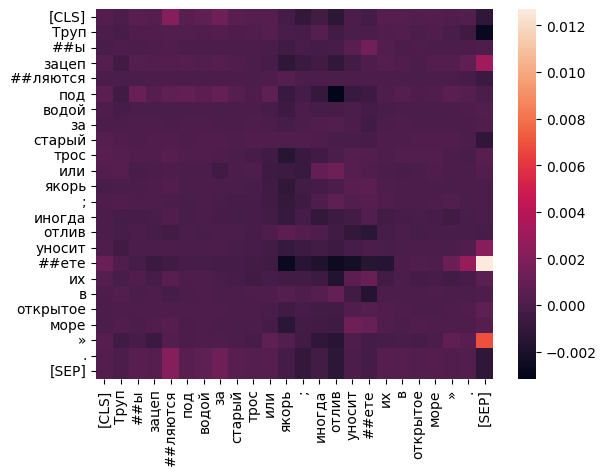

In [100]:
s = 17
t = dif_df['polypers'][s]
labs = tokenizer.convert_ids_to_tokens(tokenizer(t, return_tensors="np", truncation=True)['input_ids'][0])
sns.heatmap(np.stack(diffs['polypers'][s]), xticklabels=labs, yticklabels=labs)

In [29]:
np.concatenate(changes['polypers'])

array([0.00227356, 0.01344133, 0.00087515, ..., 0.00635727, 0.0124331 ,
       0.00448852])

In [52]:
p_c = np.concatenate(changes['polypers']) *1000
b_c = np.concatenate(changes['base'])* 1000

In [53]:
mode(p_c).mode[0], p_c.mean(), p_c.std()

/tmp/ipykernel_113708/2564218624.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode(p_c).mode[0], p_c.mean(), p_c.std()


(0.11142514785386724, 0.5839251204423386, 1.3306468820491328)

In [54]:
mode(b_c).mode[0], b_c.mean(), b_c.std()

/tmp/ipykernel_113708/367906997.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode(b_c).mode[0], b_c.mean(), b_c.std()


(0.05492227864629867, 0.4800031734785778, 1.2444865735027257)

In [67]:
df = pd.DataFrame(np.vstack([np.pad(p_c[np.argwhere(p_c<1)].reshape(-1,1),((0,0),(0,1)), 'constant', constant_values=(1)),
np.pad(b_c[np.argwhere(b_c<1)].reshape(-1,1),((0,0),(0,1)), 'constant', constant_values=(0))]), columns=['val', 'cor'])

In [62]:
import seaborn as sns

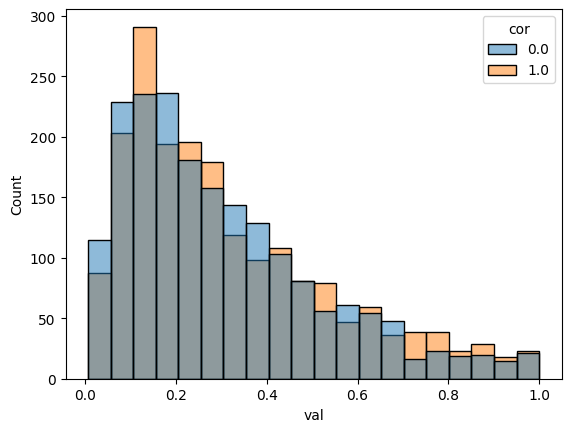

In [68]:
x = sns.histplot(data=df, x='val', hue='cor', bins=20)

(array([1.377e+03, 3.420e+02, 1.040e+02, 3.700e+01, 2.200e+01, 1.400e+01,
        3.000e+00, 1.000e+01, 6.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.14118692e-02, 4.87809164e-01, 9.64206458e-01, 1.44060375e+00,
        1.91700105e+00, 2.39339834e+00, 2.86979564e+00, 3.34619293e+00,
        3.82259022e+00, 4.29898752e+00, 4.77538481e+00, 5.25178211e+00,
        5.72817940e+00, 6.20457670e+00, 6.68097399e+00, 7.15737128e+00,
        7.63376858e+00, 8.11016587e+00, 8.58656317e+00, 9.06296046e+00,
        9.539357

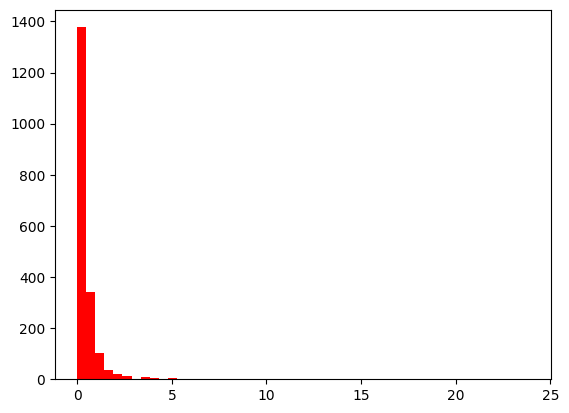

In [59]:

plt.hist(p_c[np.argwhere(p_c<1)], bins=50, color='b')
plt.hist(p_c[np.argwhere(b_c<1)], bins=50, color='r')

In [18]:
out1.attribution['ig'][0][:11] - out0.attribution['ig'][0][:11]


array([-1.41051755e-04, -7.04832726e-06,  3.55336308e-05,  3.39554377e-05,
       -2.24572580e-05,  6.33666029e-05,  1.61529401e-05, -8.85531356e-04,
        1.84473613e-04,  5.25681974e-04,  5.69938476e-04])

In [17]:
out0.attribution['ig'][0][:11]

array([0.0409113 , 0.02747081, 0.02172472, 0.03666571, 0.02289571,
       0.04275521, 0.03420676, 0.15935339, 0.05101077, 0.0662736 ,
       0.04833716])

In [ ]:
res['polypers'][0][0].attribution['ig']

In [20]:
res['base'][0] = res['base'][0][:-1]

In [11]:
res1 = {'base':{0:[], 1:[]},'polypers':{0:[], 1:[]}}
for t in ['base','polypers']:
    for flag in [0,1]:
        res1[t][flag] = [np.stack(out) for out in res[t][flag]]
        # print(len(res[t][flag]))

In [25]:
res1['polypers'][0][2].shape

(37, 64)

In [31]:
p0 = np.vstack(res1['polypers'][0])
p1 = np.vstack(res1['polypers'][1])

In [34]:
abs((p0-p1)).mean(), abs((p0-p1)).std()

(0.00020316527857642768, 0.0012820826340480262)

In [42]:
np.sort(abs(p0-p1).flatten())[::-1][:20]

array([0.17243157, 0.09544357, 0.09443364, 0.08967682, 0.07503111,
       0.07251684, 0.0696497 , 0.06340493, 0.05902478, 0.05416311,
       0.05407436, 0.05376127, 0.05344851, 0.05267371, 0.05231038,
       0.0522711 , 0.05121176, 0.04355365, 0.04282097, 0.04205654])

In [43]:
p0.flatten()[np.argsort(abs(p0-p1).flatten())[::-1][:20]]

array([0.19983199, 0.12897636, 0.03041787, 0.12255545, 0.10503583,
       0.13157672, 0.11315736, 0.01101037, 0.20759156, 0.06882063,
       0.1315627 , 0.09188041, 0.10799935, 0.10703571, 0.14826825,
       0.0685371 , 0.1611104 , 0.07512699, 0.09945709, 0.2376764 ])

In [44]:
p1.flatten()[np.argsort(abs(p0-p1).flatten())[::-1][:20]]

array([0.02740043, 0.03353279, 0.12485152, 0.03287863, 0.03000472,
       0.05905988, 0.04350766, 0.07441529, 0.26661634, 0.01465751,
       0.07748833, 0.03811914, 0.05455084, 0.05436201, 0.09595787,
       0.1208082 , 0.10989864, 0.03157334, 0.05663612, 0.27973294])

In [45]:
max_c = np.argsort(abs(p0-p1).flatten())[::-1][:20]

In [54]:
(max_c // 64)

array([ 730, 2137,  422, 2137, 2137,  372, 1769, 1479, 1334,  730,  325,
       1479, 1769, 1769,  758,  922, 1351, 1479,  220, 1342])

In [49]:
np.unique((max_c // 64), return_counts=True)


(array([ 220,  325,  372,  422,  730,  758,  922, 1334, 1342, 1351, 1479,
        1769, 2137]),
 array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3]))

In [57]:
from bisect import bisect_left

In [55]:
cs = np.cumsum(np.array(list(map(lambda x: x.shape[0], res1['polypers'][0]))))

In [70]:
[1479,1769, 2137] - cs[[bisect_left(cs, i)-1 for i in (1479,1769, 2137)]]

array([ 2,  3, 16])

In [27]:
all_res = [np.vstack(list(i.values())) for i in list(res1.values())]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [10]:
flag_diff = all_res[:,0,:,:,:] - all_res[:,1,:,:,:]

In [39]:
np.max(flag_diff[1][4][33])

0.12481090223752968

In [92]:
# out0 = res['base'][1][11]
# out1 = res['polypers'][1][11]
out0 = max_res['polypers'][0][2]
out1 = max_res['polypers'][1][2]

In [93]:
out0.n_input_tokens=0
out1.n_input_tokens=0

In [95]:
out1.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

In [96]:
out0.primary_attributions(attr_method='ig')

<IPython.core.display.Javascript object>

In [98]:
[np.argsort(abs(np.stack(out0.attribution['ig']) - np.stack(out1.attribution['ig'])).flatten())[::-1][:3] // 64,
np.argsort(abs(np.stack(out0.attribution['ig']) - np.stack(out1.attribution['ig'])).flatten())[::-1][:3] % 64]

[array([16, 16, 16]), array([12, 13, 14])]

In [128]:
inputs['poly_flag'] = torch.Tensor([0]).to(device)
inputs['poly_flag'] 

tensor([0.], device='cuda:0')

In [119]:
SEQ_LEN=1

In [137]:
a = out1.layer_predictions(position=14, topk=2, poly_flag=inputs['poly_flag'], printJson=True)

<IPython.core.display.Javascript object>

[[{'token': '##ет', 'prob': '0.0014381408', 'ranking': 1, 'layer': 0}, {'token': 'сторон', 'prob': '0.001097262', 'ranking': 2, 'layer': 0}], [{'token': '##ет', 'prob': '0.0010779102', 'ranking': 1, 'layer': 1}, {'token': '##етой', 'prob': '0.00058196025', 'ranking': 2, 'layer': 1}], [{'token': '##ет', 'prob': '0.0009000953', 'ranking': 1, 'layer': 2}, {'token': 'иногда', 'prob': '0.0004659592', 'ranking': 2, 'layer': 2}], [{'token': '##ет', 'prob': '0.00425631', 'ranking': 1, 'layer': 3}, {'token': '##ют', 'prob': '0.0017229223', 'ranking': 2, 'layer': 3}], [{'token': '##ет', 'prob': '0.002771246', 'ranking': 1, 'layer': 4}, {'token': '##ете', 'prob': '0.0014521559', 'ranking': 2, 'layer': 4}], [{'token': '##ете', 'prob': '0.012900124', 'ranking': 1, 'layer': 5}, {'token': '##ет', 'prob': '0.0048567494', 'ranking': 2, 'layer': 5}], [{'token': '##ет', 'prob': '0.02684393', 'ranking': 1, 'layer': 6}, {'token': '##ете', 'prob': '0.020065267', 'ranking': 2, 'layer': 6}], [{'token': '##ете

In [131]:
out0.layer_predictions(position=14, topk=2, poly_flag=inputs['poly_flag'])

<IPython.core.display.Javascript object>

In [14]:
from torch.nn import functional as F

In [91]:
logits.shape

torch.Size([1, 64, 119547])

In [90]:
(out0.token_ids[0] > 0).sum()

tensor(17, device='cuda:0')

In [30]:
SEQ_LEN=1

In [33]:
h[:, 5:6].shape

tensor([[0.9436]], device='cuda:0', grad_fn=<SliceBackward0>)

In [39]:
sorted_softmax[:,:,-k:]

tensor([[[ 67189,  49914,  56402,  37105, 116190,  77223,  28269,  32889,
           72885,  52131]]], device='cuda:0')

In [40]:
position=5
k = 10
top_tokens = []
probs = []
data = []
_, dec_hidden_states = out0._get_hidden_states()
dec_hidden_states = [h[:,position:position+1,:] for h in dec_hidden_states]

h = dec_hidden_states[0]
logits = model.head(h, poly_flag=inputs["poly_flag"])[0]
softmax = softmax = F.softmax(logits, dim=-1)
sorted_softmax = out0.to(torch.argsort(softmax))
layer_top_tokens = [out0.tokenizer.decode(t) for t in sorted_softmax[0,0,-k:]][::-1]
top_tokens.append(layer_top_tokens)
layer_probs = softmax[0,0,sorted_softmax[0,0,-k:]].cpu().detach().numpy()[::-1]
probs.append(layer_probs.tolist())

In [36]:
softmax.shape

torch.Size([1, 1, 119547])

In [16]:
softmax = softmax.cpu().detach()
sorted_softmax = sorted_softmax.cpu().detach()